# Investigating perplexity scores for promoter regions using varying promoter extraction techniques

In [62]:
import Bio
from Bio import SeqIO, SeqFeature
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random; random.seed(0)
import seaborn as sns

## Genbank files and general genome info

In [2]:
# 5GB1c genome (Methylomicrobium buryatense from Mitch)
gbFile_5G = 'data/5GB1c.current.gb'

# E. coli genome (https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.2)
gbFile_ecoli = 'data/ecoli_k12_NC_000913.2.gb'

In [3]:
gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()
gb_ecoli = SeqIO.parse(gbFile_ecoli, "genbank").__next__()

print("___ 5G ____")
print("Genome length:", len(gb_5G.seq), "bps")
print("num features:", len(gb_5G.features))
print("num CDS features:", len([x for x in gb_5G.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_5G.features if x.type=='gene']))

print("\n___ Ecoli ____")
print("Genome length:", len(gb_ecoli.seq), "bps")
print("num features:", len(gb_ecoli.features))
print("num CDS features:", len([x for x in gb_ecoli.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_ecoli.features if x.type=='gene']))

___ 5G ____
Genome length: 4998879 bps
num features: 8863
num CDS features: 4369
num gene features: 4427

___ Ecoli ____
Genome length: 4639675 bps
num features: 9913
num CDS features: 4321
num gene features: 4497


In [4]:
# a sampling of genbank features
for x in gb_5G.features[:5]:
    print(x)
    
for x in gb_ecoli.features[:5]:
    print(x)

type: source
location: [0:4998879](+)
qualifiers:
    Key: collection_date, Value: ['1999-01']
    Key: country, Value: ['Russia: Transbaikal']
    Key: db_xref, Value: ['taxon:95641']
    Key: isolation_source, Value: ['Soda lake sediment']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Methylomicrobium buryatense']
    Key: strain, Value: ['5GB1C']

type: gene
location: [0:1317](+)
qualifiers:
    Key: gene, Value: ['dnaA']
    Key: locus_tag, Value: ['EQU24_00005']

type: CDS
location: [0:1317](+)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: gene, Value: ['dnaA']
    Key: inference, Value: ['COORDINATES: similar to AA sequence:RefSeq:WP_006891211.1']
    Key: locus_tag, Value: ['EQU24_00005']
    Key: note, Value: ['Derived by automated computational analysis using gene prediction method: Protein Homology.']
    Key: product, Value: ['chromosomal replication initiator protein DnaA']
    Key: protein_id, Value: ['PRJNA515283:EQU24_00005']
    Key: tr

## CDS processing

In [5]:
def get_cds_coords(seq_record):
    '''
    Given a SeqRecord parsed from a genbank file, return a list of 
    all the CDS start/end coordinates and gene/locus names
    '''
    cds_list = []
    # Loop over the genome CDS features on each of the strands
    for feature in seq_record.features:
        if feature.type == 'CDS':
            # get  locus tag and gene name
            lt = feature.qualifiers['locus_tag'][0]
            g = "" if 'gene' not in feature.qualifiers else feature.qualifiers['gene'][0]
            
            cds_list.append((feature.location.start.position,
                             feature.location.end.position,
                             feature.strand,
                             lt,
                             g))
    return cds_list

In [6]:
cds_5G = get_cds_coords(gb_5G)
print(cds_5G[:10])
print()

cds_ecoli = get_cds_coords(gb_ecoli)
print(cds_ecoli[:10])

[(0, 1317, 1, 'EQU24_00005', 'dnaA'), (1502, 2603, 1, 'EQU24_00010', ''), (3060, 4140, 1, 'EQU24_00015', 'recF'), (4185, 6600, 1, 'EQU24_00020', 'gyrB'), (6825, 7062, 1, 'EQU24_00025', ''), (7098, 7257, 1, 'EQU24_00030', ''), (7350, 7734, 1, 'EQU24_00035', ''), (7818, 9075, 1, 'EQU24_00040', ''), (9071, 10241, 1, 'EQU24_00045', ''), (10240, 13306, 1, 'EQU24_00050', '')]

[(189, 255, 1, 'b0001', 'thrL'), (336, 2799, 1, 'b0002', 'thrA'), (2800, 3733, 1, 'b0003', 'thrB'), (3733, 5020, 1, 'b0004', 'thrC'), (5233, 5530, 1, 'b0005', 'yaaX'), (5682, 6459, -1, 'b0006', 'yaaA'), (6528, 7959, -1, 'b0007', 'yaaJ'), (8237, 9191, 1, 'b0008', 'talB'), (9305, 9893, 1, 'b0009', 'mog'), (9927, 10494, -1, 'b0010', 'yaaH')]


### Check that all the features in the CDS lists are indeed ordered

In [7]:
# 5G start coordinates and genome locus tags
starts = [x[0] for x in cds_5G]
print(starts == sorted(starts))
loci = [x[3].split('_')[1] for x in cds_5G]
print(loci == sorted(loci))

print()

# E coli start coordinates and genome locus tags
starts = [x[0] for x in cds_ecoli]
print(starts == sorted(starts))
loci = [x[3][1:] for x in cds_ecoli]
print(loci == sorted(loci))

True
True

True
False


In [9]:
# Seems like some ecoli genes were added between others after the fact (like hokC)... 
# probs ok...?
cds_ecoli[:20]

[(189, 255, 1, 'b0001', 'thrL'),
 (336, 2799, 1, 'b0002', 'thrA'),
 (2800, 3733, 1, 'b0003', 'thrB'),
 (3733, 5020, 1, 'b0004', 'thrC'),
 (5233, 5530, 1, 'b0005', 'yaaX'),
 (5682, 6459, -1, 'b0006', 'yaaA'),
 (6528, 7959, -1, 'b0007', 'yaaJ'),
 (8237, 9191, 1, 'b0008', 'talB'),
 (9305, 9893, 1, 'b0009', 'mog'),
 (9927, 10494, -1, 'b0010', 'yaaH'),
 (10642, 11356, -1, 'b0011', 'yaaW'),
 (11381, 11786, -1, 'b0013', 'yaaI'),
 (12162, 14079, 1, 'b0014', 'dnaK'),
 (14167, 15298, 1, 'b0015', 'dnaJ'),
 (15444, 16557, 1, 'b0016', 'insL1'),
 (16750, 16960, -1, 'b0018', 'mokC'),
 (16750, 16903, -1, 'b4412', 'hokC'),
 (17488, 18655, 1, 'b0019', 'nhaA'),
 (18714, 19620, 1, 'b0020', 'nhaR'),
 (19810, 20314, -1, 'b0021', 'insB1')]

### Quick plots to see CDS distribution

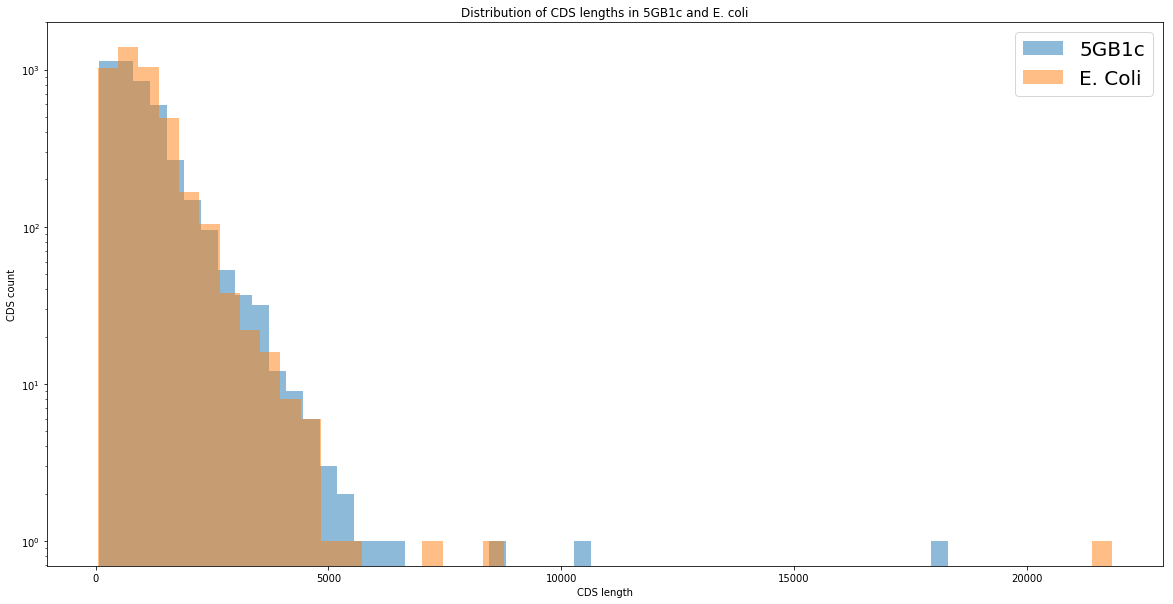

In [11]:
cds_5G_lengths = [e-s for (s,e,_,_,_) in cds_5G]
cds_ecoli_lengths = [e-s for (s,e,_,_,_) in cds_ecoli]

plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=50, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=50, label='E. Coli')
plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli")
plt.legend(fontsize = 20)
plt.show()

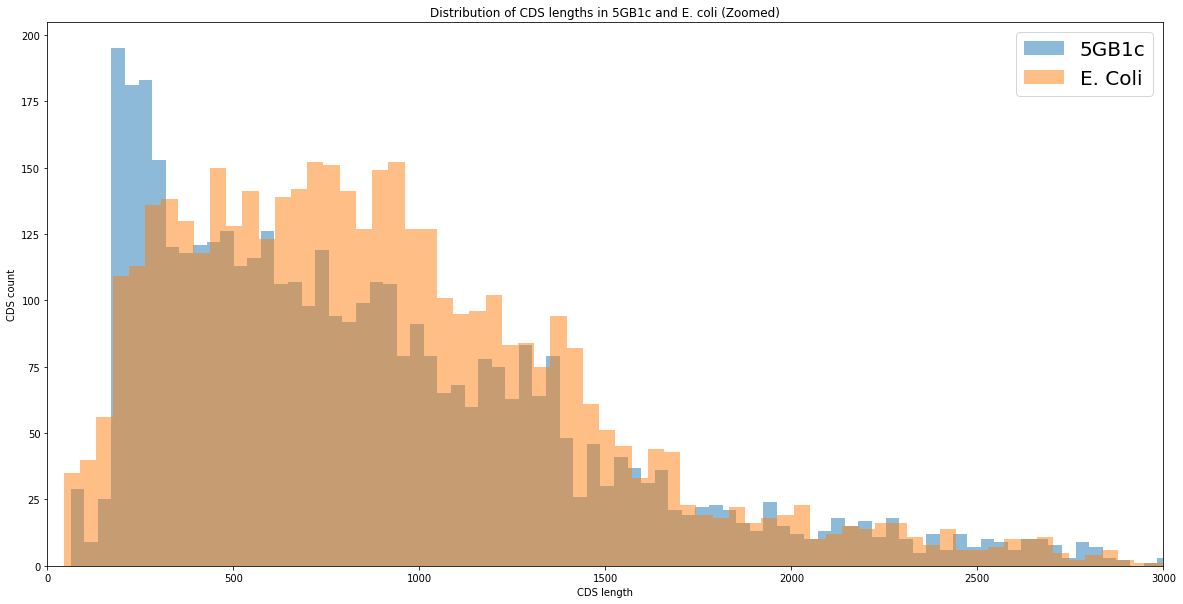

In [12]:
plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=500, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=500, label='E. Coli')

#plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli (Zoomed)")
plt.xlim(0,3000)
plt.legend(fontsize = 20)
plt.show()

### Gene locus look up dict

In [10]:
def get_locus_gene_lookup(cds_list):
    '''
    Given a list of CDSs with locus tag and gene info, return a dict mapping
    locus tag to gene name
    '''
    locus_gene_lookup = {}
    # loop through the CDS list and make a look up of locus to gene
    for x in cds_list:
        if x[4]== '':
            # if the gene name is empty, just use the locus tag
            locus_gene_lookup[x[3]] = x[3]
        # otherwise use the gene name
        else:
            locus_gene_lookup[x[3]] = x[4]

    return locus_gene_lookup

locus_gene_lookup_5G = get_locus_gene_lookup(cds_5G)
locus_gene_lookup_ecoli = get_locus_gene_lookup(cds_ecoli)

# Promoter Extraction

In [15]:
def get_promoters(gb_record, 
                  cds_list, 
                  promoter_window = 300,
                  operon_mode = False, 
                  min_gene_distance=40):
    '''
    Given a list of CDSs with (LEFT, RIGHT, STRAND, locus, gene),
    loop through and collect their promoters by getting the 300 bp
    upstream of the start codon. If in operon conscious mode, ignore 
    regions that fall within min_gene_distance bp of another gene. 
    (Won't exhaustively consider all operons but a quick-n-dirty start)
    
    Args:
      * promoter_window: how far upstream of a gene should we extract a promoter region?
      * operon_mode: When True, it will ignore upstream regions which are "too close" to the 
          current gene (aka within min_gene_distance of the start codon)
      * min_gene_distance: min distance required between the current gene and its 
          upstream neighbor otherwise we flag it as a potential operon
    '''
    promoters = [] # promoter sequence and genes they belong to
    candidate_operon_genes = [] # gene pairings that are potentially in the same operon
    operon_locs = [] # mid point in intergenic distance between two genes which have been 
                     # flagged as potentially in an operon
    
    # loop through all CDSs
    for i,(g_left,g_right,strand,locus,gene) in enumerate(cds_list):
        # keep track of whether or not to skip operon
        operon_skip_flag = False
        
        gene_string = "%s|%s" % (locus, gene)
        
        # +-----------------+
        # | NEGATIVE STRAND |
        # +-----------------+
        # if we're on the negative strand, go 300bp to the right, reverse compelement
        if strand == -1:
            # get the range of the promoter region
            p_left = g_right + 1
            p_right = p_left + promoter_window
            
            # extract actual DNA
            seq = gb_record.seq[p_left:p_right]
            
            # if we're in operon mode and this isn't the last gene (aka no rightward operon),
            # check the min_distance window for other annotations
            if operon_mode and i < len(cds_list) -1:
                # get the FOLLOWING feature (because on -1 strand)
                upstream_gene = cds_list[i+1]
                # if the left side of the upstream gene is within min_distance
                if (
                    upstream_gene[0] < (g_right + min_gene_distance) and
                    upstream_gene[2] == strand # and same strand 
                ): 
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_right + upstream_gene[0])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))

        # +-----------------+
        # | POSITIVE STRAND |
        # +-----------------+
        # if we're on the positive strand, go 300bp to the left
        else:
            # get the range of the promoter region
            p_right = g_left - 1 
            p_left = p_right - promoter_window
            
            # extract actual DNA
            seq = gb_record.seq[p_left:p_right].reverse_complement()
            
            # if we're in operon mode and this isn't the first gene (aka no leftward operon),
            # check this window for other annotations
            if operon_mode and i != 0:
                # get the PREVIOUS feature (because on +1 strand)
                upstream_gene = cds_list[i-1]
                # if the right side of the upstream gene is within min_distance
                if (
                    upstream_gene[1] > (g_left - min_gene_distance) and 
                    upstream_gene[2] == strand # and same strand
                ):
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_left + upstream_gene[1])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))
        
        # To skip or NOT to skip?
        if not operon_skip_flag:
            promoters.append((gene_string, str(seq)))
            
    return promoters, operon_locs, candidate_operon_genes
        
        

In [32]:
# 5G
print("5G")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_5G,_,_ = get_promoters(gb_5G,cds_5G)
print("Num naive promoters:", len(naive_p_set_5G))

# use operon ignorant conscious strategy to extract promoters
operon_p_set_5G, operon_locs_5G, op_cand_5G = get_promoters(gb_5G, cds_5G, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_5G))
print()

# Ecoli
print("E. Coli")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_ecoli,_,_ = get_promoters(gb_ecoli,cds_ecoli)
print("Num naive promoters:", len(naive_p_set_ecoli))

# use operon ignorant conscious strategy to extract promoters
operon_p_set_ecoli, operon_locs_ecoli, op_cand_ecoli = get_promoters(gb_ecoli, cds_ecoli, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_ecoli))


5G
Num naive promoters: 4369
Num operon promoters: 2840

E. Coli
Num naive promoters: 4321
Num operon promoters: 2819


In [33]:
print(naive_p_set_5G[:6])
print()
print(operon_p_set_5G[:6])
# ^^ Sanity check: operon_p_set has decided to skip EQU24_00030!

[('EQU24_00005|dnaA', 'ATTTAAGAAGGTAGCGAAGAGTAAATAGATGATATTATAAAAAAATTATGCCACTATACAGCAATCAAATCAGTGCCGGCATAATTGACATAAACCGGCGTTTATTCTATCATCCCGGATCTTTTTTATCCGTTTTTGTTAACAATCATCTGAACCAGGATTTAAGGCCATGAAAAGAACCTATCAACCCAGTAAAATTAAACGCGTAAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGTAAAGTCCTTAACGCCCGCAGAGCCAAGGGCCGTGCCAAGCTAACAGT'), ('EQU24_00010|', 'TAAGATATTTATTTATATTTACTATTAGCCTATAAAAAAAGCGTGATAAGTCATTTTTTATTTTATTTATCAATAGCTTATGAACTGTAAAACCGGCGTTTAAAGCTGTGGATAAGCGCTTGATAAAAAGAGGATAACTCTCCTTCTCTGCTAAAGACTATAGTTATCCACAAGTTAAACACCGTTAATGCGACAATGTTCTCAACAGGTTTAAATAATCTTCCTCAAGCTTTACATCCGAATCACGTAAAGAAGCAATGCGTTTACAAGCATTAATAACCGTGGTGTGATCGCGTCCAC'), ('EQU24_00015|recF', 'GTTTATTAGTTGCTAGTCAAAAAAAGCACGCGGTTAACACCGGTTAGATGAACAACAAGCTCGTTTTTTTGTTGCTTCCACATTTAATAATGACTGCGATTTAGAAATTTCAGGAAGTTAGTGAAAAGTTGACCTTAACGTTCATGAAAGCCAGGTCATCGCCCCGGAAAATGAAAGCTCTGGGTAGCTGAGGGTGCGGTCACTCGACCGACAGGACACCGTGAATACGTCCGTGTAGGCTTGACGGCGGCTATCCTTGCCGCCGACGCCTGTCGGACGAGAAACCGCCCCTCTTCGCAA'), ('EQU24_00020|gyrB', 'TGT

### Some sanity check plotting to see if what I'm calling possible operons sounds reasonable

In [34]:
# get the genome coordinates as the x-axis, use the strand as the y axis
cds_strand_temp_5G = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_5G)]
cds_strand_temp_ecoli = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_ecoli)]

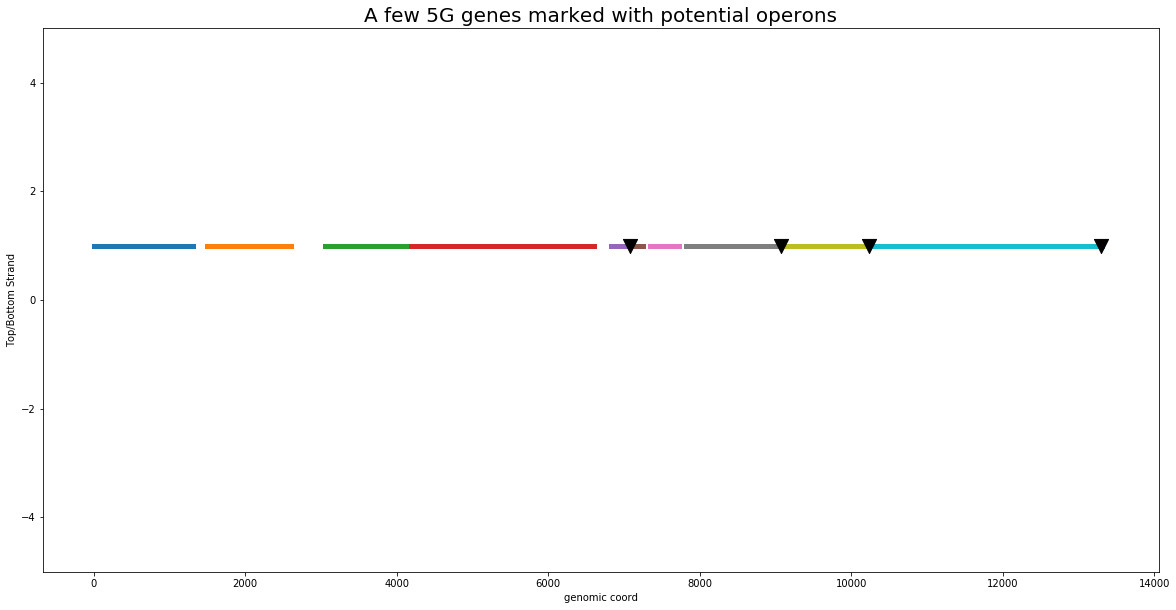

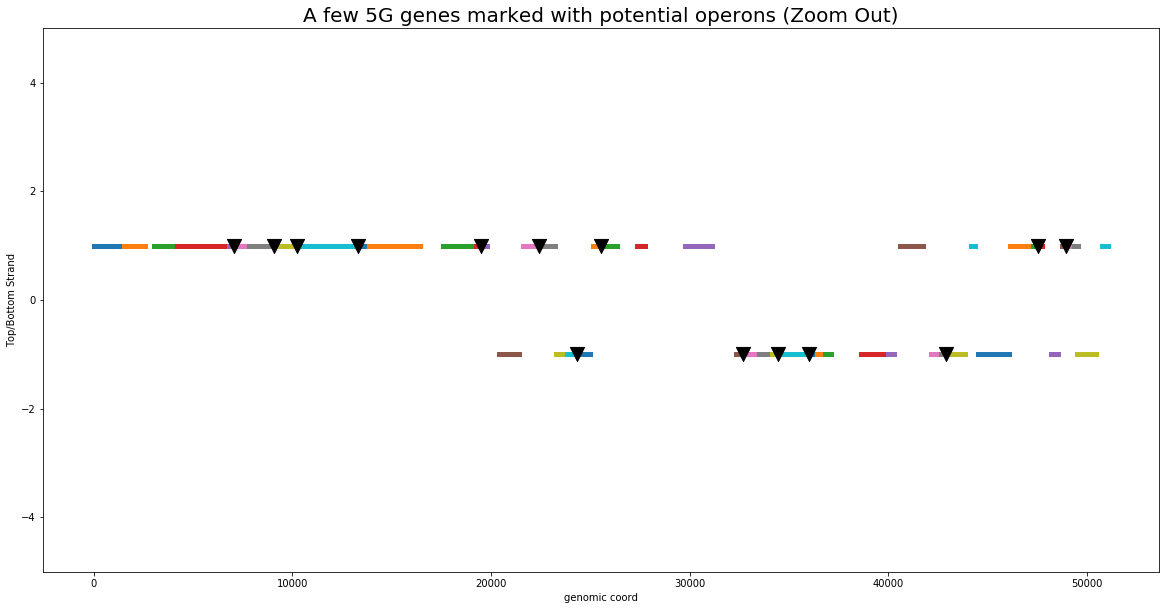

In [41]:
# plot the first few genes along the 5G genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:10]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:14]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

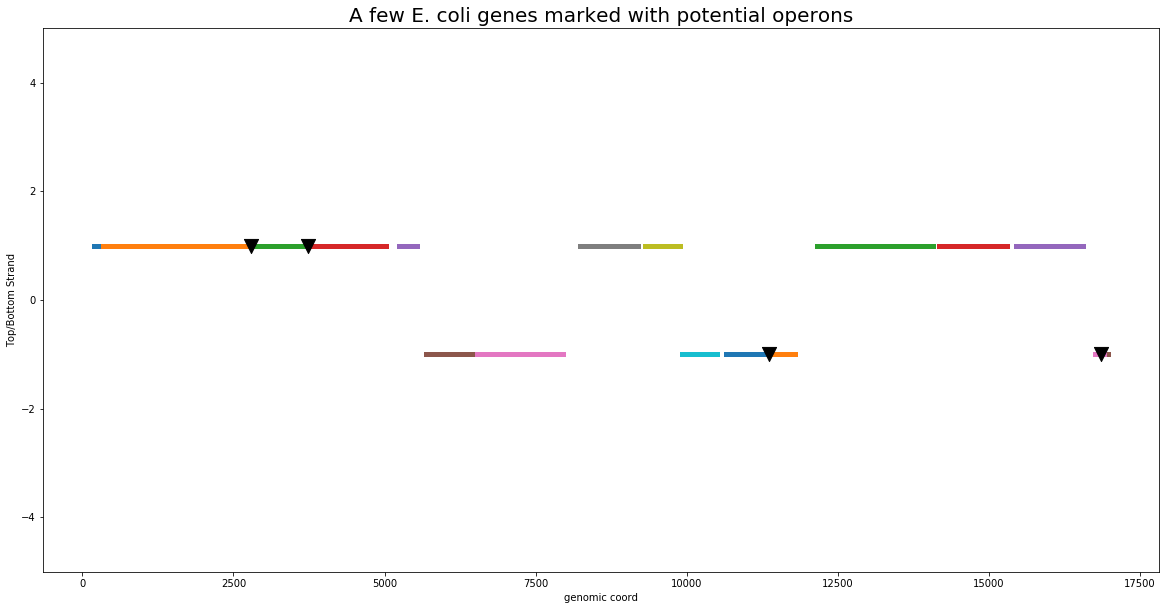

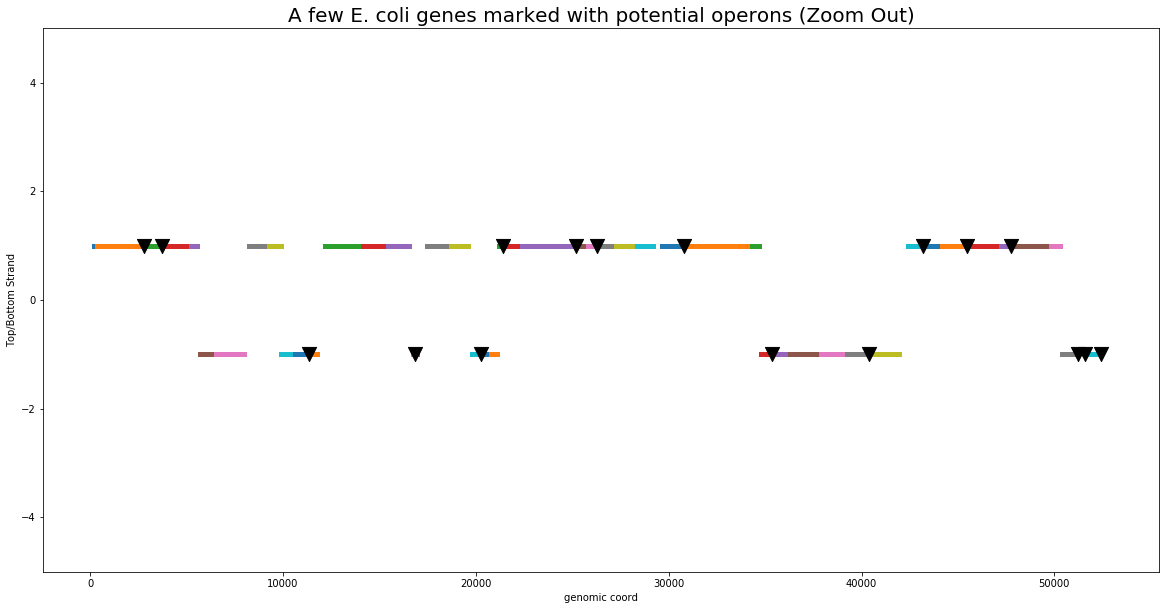

In [42]:
# plot the first few genes along the 5G genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:17]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:17]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

### Make some truly random "promoter sets"
Take random 300 bp sections from the genome and scramble them

In [86]:
def generate_randomized_seqs(seq_record, name, k, promoter_window=300):
    '''
    Given a SeqRecord from genbank, generate k random sequences by extracting
    windows of size promoter_window then shuffling the sequence. The shuffling should 
    prevent us accidentally slicing out a actual promoter region but the fact that its
    not generated purely by an RNG means that the general frequency of bases should be
    preserved. 
    '''
    rand_seqs = []
    genome_length = len(seq_record.seq)
    
    # for as many promoters as we want to generate:
    for i in range(k):
        seq_name = "%s_RANDOM_%i" % (name, i)
        # pick a random location in the genome (not too close to the end)
        rand_loc = random.randint(0,genome_length-promoter_window)

        # get the sequence in that location
        seq = str(seq_record.seq[rand_loc:rand_loc+promoter_window])
        
        # shuffle the sequence
        rand_seq = ''.join(random.sample(seq,len(seq)))
        rand_seqs.append((seq_name,rand_seq))
        
    return rand_seqs

In [87]:
rand_proms_5G = generate_randomized_seqs(gb_5G,"5G", 4000)
rand_proms_ecoli = generate_randomized_seqs(gb_ecoli,"ECOLI", 4000)

In [90]:
rand_proms_5G[:5]
rand_proms_ecoli[:5]

[('ECOLI_RANDOM_0',
  'CGGACGAAGAAGCGCGTAAAGCGCCTTTGCTGAGTATGCGTGTCCGCTCTCGCGGTGGTTGACCTGATTAGAACTTGCTCGTGCCCTATTGGCCCACTTTAGGAGCGTTGATTTGGATTCGGCCGGAAAGCCTCTATCTGGCAATGATCCTTCTAGTTAATTACGCTGTCGGCTATACTTGGTAGGTCCCACCGTAAATGGGCAGCCACAATGTGCGTGTCCTGGCCCGGTCTAGCTCCGAAATATCGTTCAGCGCTCGAATGTTCGTTGTGGGTCATATCAGCCCGTGTGTGCGGTGCA'),
 ('ECOLI_RANDOM_1',
  'CAAAAGCGCCAAACTAGCCCCGTCCAGACCGCTGTCCCATTAGTCAAATCGCACACGGCGTATGTGCCCTAGTGCCTTGTACCGAAATGTGCGCGGAGAAGGTGCTTATGTTCGCAATTACACTACCTCCAAATCCTCGTTATAATCATGTATAGCCCTGTTCGAGCGAGCCTAGACGCGCCTGTTGCAGGGGAGCGCTGGCCCATTAGAATACACATTGGCCATAGTAGATCGGCCGGGTCCATGACTGCGCCAGGACTATATTGTACATGACGCACAATCACGCTTCGACTTGCCACA'),
 ('ECOLI_RANDOM_2',
  'GGCCTTGTGCACAGCTATTGGGTGGTTTTCGCATTCCTTCGCGTGGCAGGGGCGTGGATGCGGATCCCCGGGGCGCCTGGTACTACACTTGGACACCCGAGGTCGTCTGATCTTCTTTTAGTCAGTCGCTGAGACCAGACTGGCAGGGATAAGTGGCGCCTCGCCAGAGTGCGACGGGTCGTTGTAGTGCTCAGGGAGTTCACGGCATGTCATCCAGATCGGCTTTTTAATTGTTCGGACGATATCAAACAGAGGTTGCCTACGTTGCTCTCCAAATGCACTTTATATAGAGCTGAAGCC'),
 ('ECOLI_RANDOM_3',

## RegulonDB predicted promoters

In [140]:
regdb_df = pd.read_csv("data/regulon_db_ecoli_promoters.tsv", sep='\t')

# filter out Sigma38 because doesn't have -35 data
regdb_df = regdb_df.loc[regdb_df['(6)Sigma']!='Sigma38']

In [141]:
print(regdb_df.columns)
regdb_df.head(10)

Index(['(1)Lend', '(2)Rend', '(3)Strand', '(4)Gene', '(5)Promoter_Name',
       '(6)Sigma', '(7)-35Box_Lend', '(8)-35Box_Rend', '(9)-35Box',
       '(10)Spacer', '(11)-10Box_Lend', '(12)-10Box_Rend', '(13)-10Box',
       '(14)Pos_1', '(15)Score', '(16)Homology_Level', '(17)P-value',
       '(18)Signicance_Level', '(19)Evidence', '(20)EvidenceType',
       '(21)Sequence'],
      dtype='object')


,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(12)-10Box_Rend,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,6600,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,10603,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,51304,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,60462,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,79605,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,87859,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,118675,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,131320,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,135664,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,144958,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac


### Sanity check that RegulonDB coordinates produce the same sequence when extracted from the genbank file as the reported sequence column

In [142]:
def get_prom_reg(row):
    '''
    Sanity check. 
    If forward, left side is the -35 Box and right side is the Pos_1
    If reverse, left side is Pos_1 and right side is -35 Box. Also, reverse complement the seq
    
    Add buffer sequences on the left of 6 and right of 5
    '''
    if row['(3)Strand'] == 'F':
        l = int(row['(7)-35Box_Lend']) - 6
        r = int(row['(14)Pos_1']) + 5
        seq = ''.join(gb_ecoli.seq[l:r])
        
    elif row['(3)Strand'] == 'R':
        l = int(row['(14)Pos_1']) - 6
        r = int(row['(8)-35Box_Rend']) + 5
        seq = ''.join(gb_ecoli.seq[l:r].reverse_complement())
        
    return seq

In [143]:
regdb_df['test_prom'] = regdb_df.apply(lambda x: get_prom_reg(x), axis=1)
regdb_df.head(10)

,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence,test_prom
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg,CAGCGTAAACTCGGCGTGCGCCCGGTGTTTGATCCATTGCGTTATCCGG
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca,CCGGGGAAAATTTTCATTTTCCCCTCAAAAGATCGTAGACACTGCCCCA
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg,CGCTGGGCACCATGCAGGGTCACTACGAAATGATCGATGAAAATGGCG
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag,TGCAGTGAACCCGAACATTCGTGACGACGAACTGACCGCCATTGAG
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct,GGCGATGAACAACGACCGTCTGAATCCGGGCGAACGTTGTGCCT
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt,GGCGATAAAATAATGCGTTGAGAATGATCTCAATGCGCAATT
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca,CATGTTAAAACTCCAGATAGCTAACGAATCATAAGGTAGAAACA
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt,AAATTTAAACTACCGCCTCTTTATACTCGGATTCACAGCACCTGCGGGT
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt,TGGCCTGAAATGCCGTTATTACAATCCGGCAATCCATACGGCAGCTTT
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac,ATTGTCGAACTGGGTGCGCCGGAGGTGAGTAGTCTTTGGCACCAACAAC


In [154]:
sum(regdb_df['test_prom'] != regdb_df['(21)Sequence'].apply(lambda x: x.upper()))
# ^^ Indeed the test_prom and (21)Sequence columns match! (All False sums to 0)

0